<a href="https://colab.research.google.com/github/olegtyulyaev/--2/blob/main/Attestation_2_semestr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Задача №1

* Подведите результаты эксперимента в экселе по следующим данным: ab_stats.csv
* Стат значимо ли отличается ARPPU в двух группах?
* Какие рекомендации дадите менеджеру?

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns


from scipy.stats import norm, t, kstest, shapiro
import statsmodels.api as sm
from matplotlib import pyplot as plt

from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.proportion import proportions_chisquare
from statsmodels.stats.power import TTestIndPower

import scipy.stats as stats
from scipy.stats import ttest_ind

import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

In [14]:
df = pd.read_csv('ab_stats.csv')
df.head(15)

,revenue,num_purchases,purchase,ab_group,av_site visit
0,0.0,0,0,A,9.040174
1,0.0,0,0,A,4.811628
2,0.0,0,0,A,7.342623
3,0.0,0,0,A,7.744581
4,0.0,0,0,A,10.511814
5,0.0,0,0,A,9.578727
6,0.0,0,0,A,6.162601
7,0.0,0,0,A,11.909452
8,0.0,0,0,A,6.540910
9,0.0,0,0,A,7.990794


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23652 entries, 0 to 23651
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   revenue        23652 non-null  float64
 1   num_purchases  23652 non-null  int64  
 2   purchase       23652 non-null  int64  
 3   ab_group       23652 non-null  object 
 4   av_site visit  23652 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 924.0+ KB


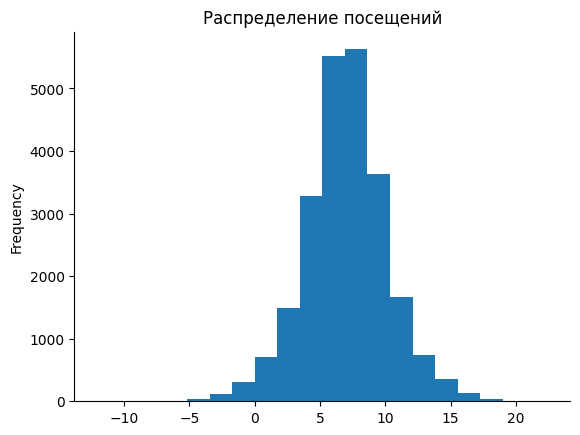

In [15]:
from matplotlib import pyplot as plt
df['av_site visit'].plot(kind='hist', bins=20, title='Распределение посещений')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [16]:
# Оценим базовую статистику датасета
df.describe()

,revenue,num_purchases,purchase,av_site visit
count,23652.000000,23652.000000,23652.000000,23652.000000
mean,0.324689,0.043590,0.020717,7.013112
std,9.557730,1.079403,0.142438,3.154584
min,0.000000,0.000000,0.000000,-12.073486
25%,0.000000,0.000000,0.000000,5.173787
50%,0.000000,0.000000,0.000000,7.007936
75%,0.000000,0.000000,0.000000,8.864119
max,1303.609284,152.000000,1.000000,22.446822


По посещаемости и графически и статистически видны нелогичные минуса, вплоть до -12

In [19]:
# Исключение записей о пользователях, которые дали минусы
df = df.drop(df.loc[df['av_site visit']<0].index)

In [25]:
# Посмотрим как поменялась статистика после чистки
df.describe()

,revenue,num_purchases,purchase,av_site visit
count,23184.000000,23184.000000,23184.000000,23184.000000
mean,0.326511,0.043780,0.020704,7.188254
std,9.645839,1.089462,0.142394,2.924011
min,0.000000,0.000000,0.000000,0.008679
25%,0.000000,0.000000,0.000000,5.314379
50%,0.000000,0.000000,0.000000,7.068656
75%,0.000000,0.000000,0.000000,8.910900
max,1303.609284,152.000000,1.000000,22.446822


Вычистилось 468 записей или 1,97% выборки. Не критично по объему, но надо разобраться какие данные давали минуса, чтобы в следуюзих жкспериментах сразу было меньше шума.

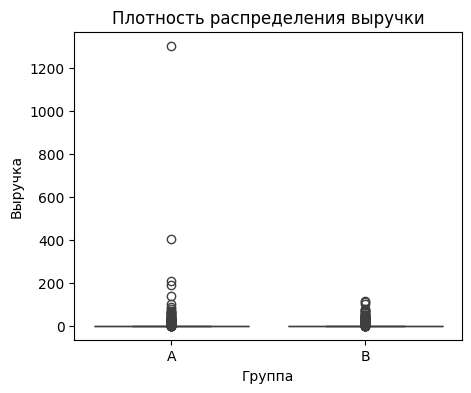

In [23]:
# Визуализация данных по выручке, с учетом очищенных данных
plt.figure(figsize=(5,4))
ab_net = sns.boxplot(data= df, x='ab_group', y='revenue')
plt.title('Плотность распределения выручки')
plt.ylabel('Выручка')
plt.xlabel('Группа')
plt.show()

В группе А наблюдаются выносы по выручке, возможно сэмплирование не очень качественное было

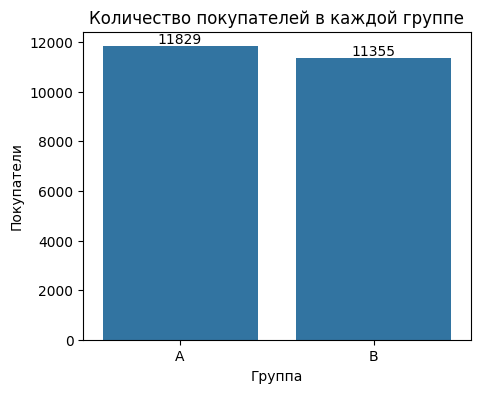

In [24]:
# визуализация наполненности исследуемых групп после очистки данных
plt.figure(figsize=(5,4))
ab_players = sns.countplot(data=df, x='ab_group')
plt.title('Количество покупателей в каждой группе')
plt.ylabel('Покупатели')
plt.xlabel('Группа')
ab_players.bar_label(ab_players.containers[0])
plt.show()